In [1]:
from models import CMGN, MMGN, MLP
from models import GMMSampler, MMDDistance, DualWassersteinDistance, GaussianKLDivergence

## First example: Transporting Gaussian Distributions

We model how to transport simple gaussian distributions. We test:
- Using the KLL between the estimated density, consdidered Gaussian, and the target density.
- Using the KL Divergence with the same setup.
- Using the Wasserstein Distance between the generated points and the target distribution, in an adversarial fashion.

Let's begin by generating some example data:

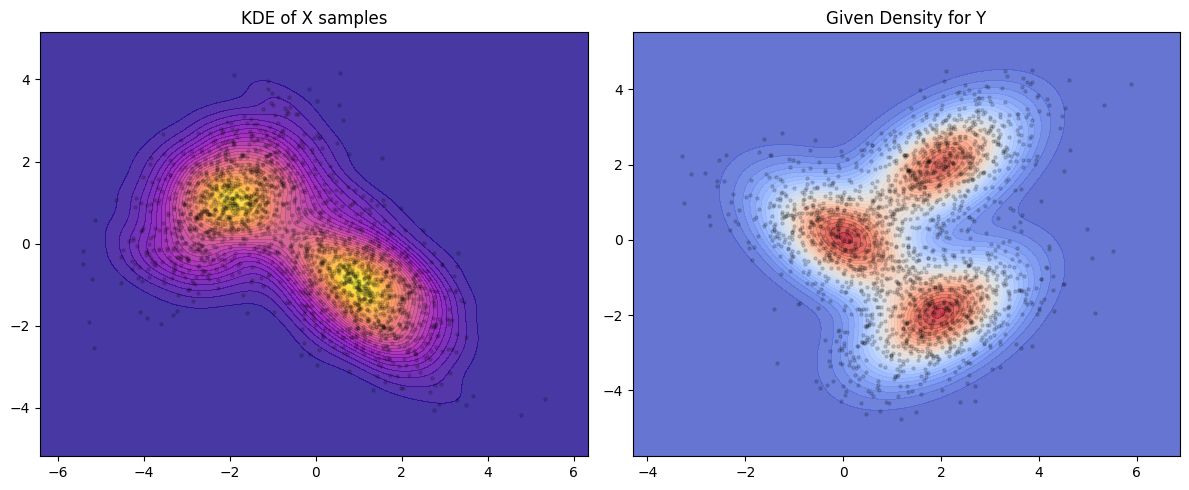

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from plot_utils import plot_kde_comparison

x_gmm_centers = np.array([[-2, 1], [1, -1]])
x_covs = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]])

# x_gmm_centers = np.array([[-3, 1]])
# x_covs = np.array([[[2, 2], [2, 3]]])

x_gmm = GMMSampler(x_gmm_centers, covs=x_covs, weights=None)



# y_gmm_centers = np.array([[0, 0]])
# y_covs = np.array([[[1, 0.5], [0.5, 1]]])
# y_gmm = GMMSampler(y_gmm_centers, covs=y_covs, weights=None)

# If we want a more complex distribution
y_gmm_centers = np.array([[2, 2], [0, 0], [2, -2]])
y_covs = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[1, 0.5], [0.5, 1]]])
y_gmm = GMMSampler(y_gmm_centers, covs=y_covs, weights=None)

n_samples = 2000
x_samples = x_gmm.sample(n_samples)
y_samples = y_gmm.sample(n_samples)
p_y = lambda y: torch.exp(y_gmm.log_likelihood(torch.Tensor(y).T))

plot_kde_comparison(x_samples, y_samples, p_y=p_y, left_title='KDE of X samples')

In [3]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from IPython.display import HTML

def plot_kde(samples, ax, cmap, density_fn=None, scatter=True):
    x, y = samples[:, 0], samples[:, 1]

    # Define grid
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

    # Compute density
    if density_fn:
        zz = density_fn(xx, yy)
    else:
        kde = gaussian_kde(np.vstack([x, y]))
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # Plot
    ax.contourf(xx, yy, zz, levels=30, cmap=cmap, alpha=0.8)
    if scatter:
        ax.scatter(x, y, s=5, color='black', alpha=0.3)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

def train_OT(source_sampler, target_sampler, learning_rate, iterations, model, batch_size, distribution_distance, plot_every_n=10, lmbd=0.1, device='cuda', p_y=None, visualize=True):
    losses = []
    T_x_history = []

    gradient_net = model.to(device)  # gradient net = ∇ψ = T = ce qu'on veut apprendre
    optimizer = torch.optim.Adam(gradient_net.parameters(), lr=learning_rate)

    # Create a tqdm progress bar
    progress_bar = tqdm(range(iterations), desc="Training Progress")

    for i in progress_bar:
        x_batch = source_sampler.sample(batch_size).to(device)
        y_batch = target_sampler.sample(batch_size).to(device)

        T_x = gradient_net(x_batch) / 25

        # Compute distribution matching penalty
        loss = distribution_distance(T_x, y_batch)


        # Total loss
        losses.append(loss.item())

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if hasattr(distribution_distance, 'update'):
            T_x = T_x.detach()
            distribution_distance.update(T_x, y_batch)


        # Store the transported samples for animation
        if i % plot_every_n == 0:
            T_x_history.append(T_x.detach().cpu().numpy())

        if i % 500 == 0 and visualize:
            with torch.no_grad():
                T_x_np = T_x.detach().cpu().numpy()
                y_samples = y_batch.detach().cpu()
                if p_y is None:
                    p_y = lambda y: torch.exp(y_gmm.log_likelihood(torch.Tensor(y).T)).cpu().numpy()
                plot_kde_comparison(T_x_np, y_samples, p_y=p_y, left_title='KDE of X samples')

    # Smooth the loss curve using a moving average
    window_size = 10
    smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

    # Plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Loss', alpha=0.6)
    plt.plot(range(window_size-1, iterations), smoothed_losses, label='Smoothed Loss', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Iterations')
    plt.grid(True)
    plt.legend()
    plt.xticks(range(0, iterations, 50))
    plt.show()

    if not visualize:
        return gradient_net

    # Compute the limits for the plot
    all_samples = np.vstack(T_x_history)
    # xmin, xmax = all_samples[:, 0].min() - 1, all_samples[:, 0].max() + 1
    # ymin, ymax = all_samples[:, 1].min() - 1, all_samples[:, 1].max() + 1

    # use quantiles instead of min/max to avoid outliers
    q = 0.05
    xmin, xmax = np.quantile(all_samples[:, 0], q), np.quantile(all_samples[:, 0], 1-q)
    ymin, ymax = np.quantile(all_samples[:, 1], q), np.quantile(all_samples[:, 1], 1-q)

    # Compute mean and covariance for y samples
    y_samples = target_sampler.sample(batch_size).cpu().numpy()
    y_mean = np.mean(y_samples, axis=0)
    y_cov = np.cov(y_samples, rowvar=False)

    # Create an animation for the evolution of T_x
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_ylim(ymin, ymax)
    axes[1].set_xlim(xmin, xmax)
    axes[1].set_ylim(ymin, ymax)

    # Plot the target distribution (assuming p_y is available)
    density_fn = lambda X, Y: p_y(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    plot_kde(T_x_history[0], axes[1], cmap='coolwarm', density_fn=density_fn, scatter=False)
    axes[1].set_title('Target Distribution')

    def init():
        axes[0].clear()
        axes[0].set_xlim(xmin, xmax)
        axes[0].set_ylim(ymin, ymax)
        return []

    def animate(i):
        axes[0].clear()
        axes[0].set_xlim(xmin, xmax)
        axes[0].set_ylim(ymin, ymax)

        T_x_np = T_x_history[i]
        plot_kde(T_x_np, axes[0], cmap='plasma')
        axes[0].set_title(f'Iteration {i * plot_every_n}')

        # Compute mean and covariance for T_x samples
        T_x_mean = np.mean(T_x_np, axis=0)
        T_x_cov = np.cov(T_x_np, rowvar=False)

        # Plot mean and covariance for T_x samples
        T_x_mean_plot = axes[0].scatter(T_x_mean[0], T_x_mean[1], color='red', s=100, zorder=5, label='Mean of T_x')
        T_x_cov_plot1 = axes[0].arrow(T_x_mean[0], T_x_mean[1], T_x_cov[0, 0], T_x_cov[0, 1], color='red', head_width=0.1)
        T_x_cov_plot2 = axes[0].arrow(T_x_mean[0], T_x_mean[1], T_x_cov[1, 0], T_x_cov[1, 1], color='red', head_width=0.1)

        # Plot mean and covariance for y samples
        y_mean_plot = axes[0].scatter(y_mean[0], y_mean[1], color='blue', s=100, zorder=5, label='Mean of y')
        y_cov_plot1 = axes[0].arrow(y_mean[0], y_mean[1], y_cov[0, 0], y_cov[0, 1], color='blue', head_width=0.1)
        y_cov_plot2 = axes[0].arrow(y_mean[0], y_mean[1], y_cov[1, 0], y_cov[1, 1], color='blue', head_width=0.1)

        # Add legend
        axes[0].legend(handles=[T_x_mean_plot, y_mean_plot], loc='upper right')

        return []

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(T_x_history), interval=200, blit=False)

    # Save the animation as a video file
    video_path = 'transported_samples_animation.mp4'
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(video_path, writer=writer)

    # Display the video in the notebook
    return HTML(f"""
        <video width="640" height="480" controls>
            <source src="{video_path}" type="video/mp4">
        </video>
    """)

# Example usage
# gradient_net = train_OT(source_sampler, target_sampler, learning_rate, iterations, model, batch_size, distribution_distance, plot_every_n=10)


Number of parameters: 6945
Batch size: 8192


Training Progress:   0%|          | 0/20000 [00:11<?, ?it/s, loss=1.18]


KeyboardInterrupt: 

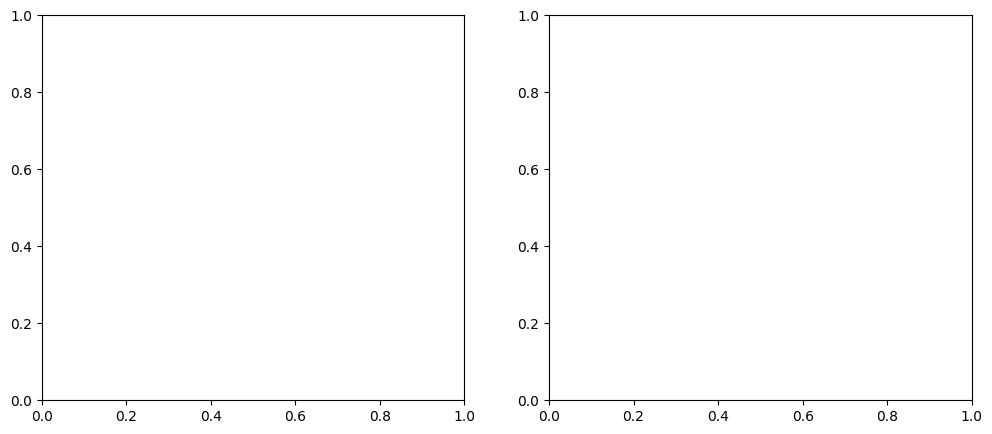

In [4]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_dim = x_gmm.means[0].shape[0]
hidden_dim = 96
v_dim = 4
num_layers = 6
slope = 0.1
activation = nn.LeakyReLU(slope)

activation_antiderivative = lambda x: (.5 * x**2 * ((x > 0).float() + slope *  (x <= 0).float()) ).sum(dim=-1).unsqueeze(-1)

# T = CMGN(hidden_dim, v_dim, x_dim, num_layers, activation).to(device) # Notre transport
# T = MMGN(x_dim, v_dim, hidden_dim, num_layers, activation, activation_antiderivative)

from models import create_icnn_for_ot

T = create_icnn_for_ot(x_dim)

# Nombre de paramètres du modèle:
print(f'Number of parameters: {sum(p.numel() for p in T.parameters())}')

learning_rate = 2e-4
iterations = 20000
batch_size = 2**13
print(f'Batch size: {batch_size}')

plot_every_n = 100


divergence_metric = GaussianKLDivergence(target_mean=y_gmm.means[0], target_cov=y_gmm.covs[0], device=device)

# divergence_metric = DualWassersteinDistance(
#     input_dim=2, 
#     hidden_dim=32,
#     critic_lr=2e-4,
#     critic_iterations=1,
#     lambda_gp=10

# )
# divergence_metric.critic.to(device)

# Create MMD distance calculator
# mmd_distance = MMDDistance(kernel_width=0.5)




train_OT(
    x_gmm, 
    y_gmm, 
    learning_rate, 
    iterations, 
    T, 
    batch_size, 
    divergence_metric, 
    device=device,
    plot_every_n=plot_every_n
)

In [ ]:
df

In [ ]:
sffsdfs

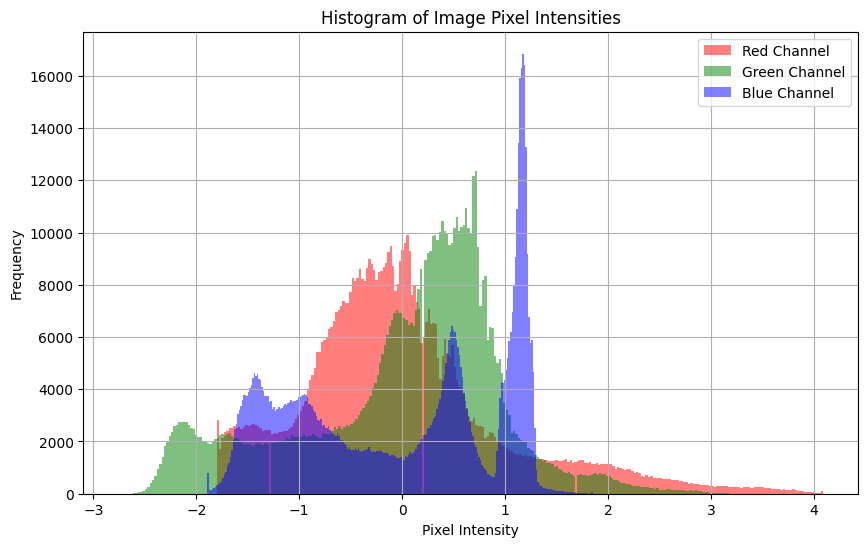

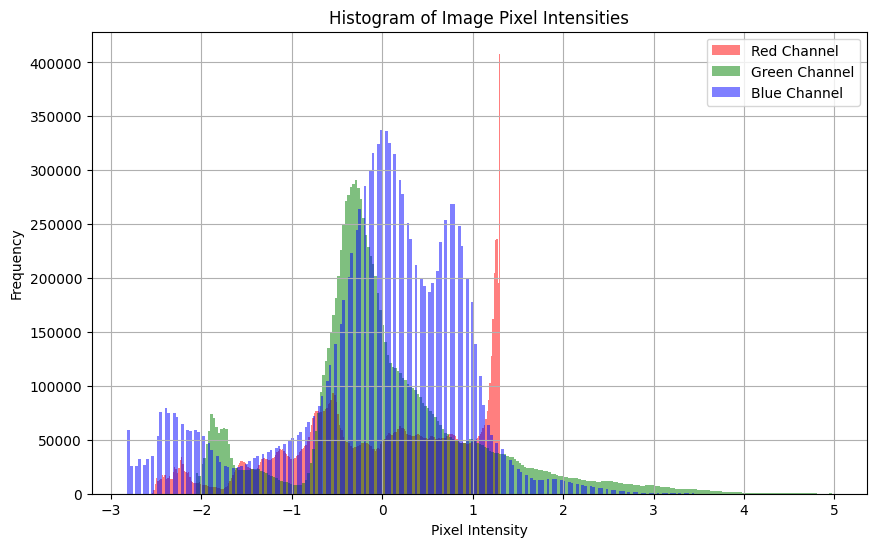

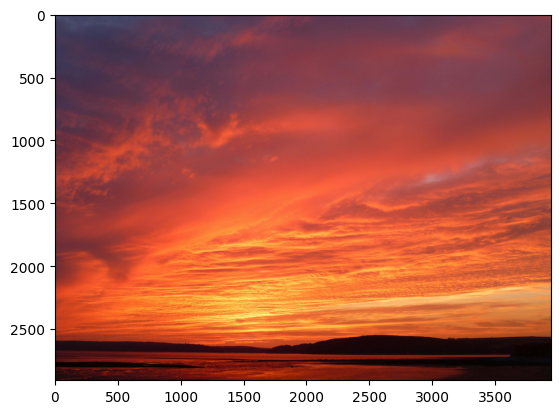

In [ ]:
class ImageSampler:
    def __init__(self, filename):
        self.points = plt.imread(filename)
        self.points = self.points.reshape(-1, 3).astype(np.float32)
        self.points = (self.points - self.points.mean(axis=(0))[None, :]) / self.points.std(axis=(0))[None, :]
        self.filename = filename

    def sample(self, n_samples):
        indices = np.random.choice(len(self.points), n_samples)
        return torch.Tensor(self.points[indices])
    
    def plot(self):
        plt.figure(figsize=(10, 6))
        plt.hist(self.points[:, 0], bins=256, color='red', alpha=0.5, label='Red Channel')
        plt.hist(self.points[:, 1], bins=256, color='green', alpha=0.5, label='Green Channel')
        plt.hist(self.points[:, 2], bins=256, color='blue', alpha=0.5, label='Blue Channel')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.title('Histogram of Image Pixel Intensities')
        plt.legend()
        plt.grid(True)
        plt.show()

    def show_image(self):
        plt.imshow(plt.imread(self.filename))

x_image_sampler = ImageSampler('test_images/montagne.jpg')
y_image_sampler = ImageSampler('test_images/sunset.jpeg')

x_image_sampler.plot()
y_image_sampler.plot()

x_image_sampler.show_image()
y_image_sampler.show_image()

Number of parameters: 339
Batch size: 8192


Training Progress:   0%|          | 0/20000 [00:00<?, ?it/s, loss=0.404]

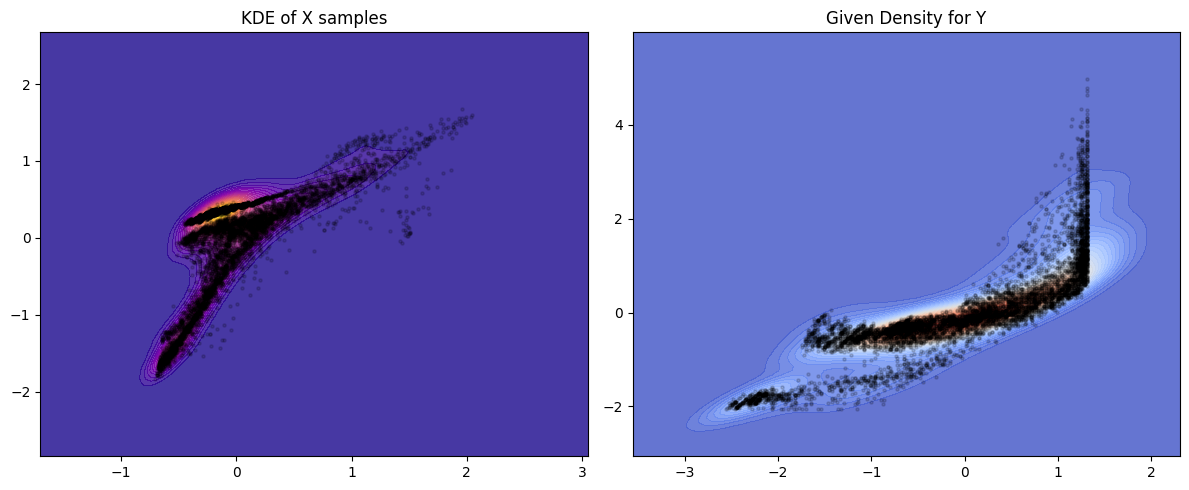

Training Progress:   2%|▏         | 497/20000 [00:14<08:19, 39.08it/s, loss=1.91]  

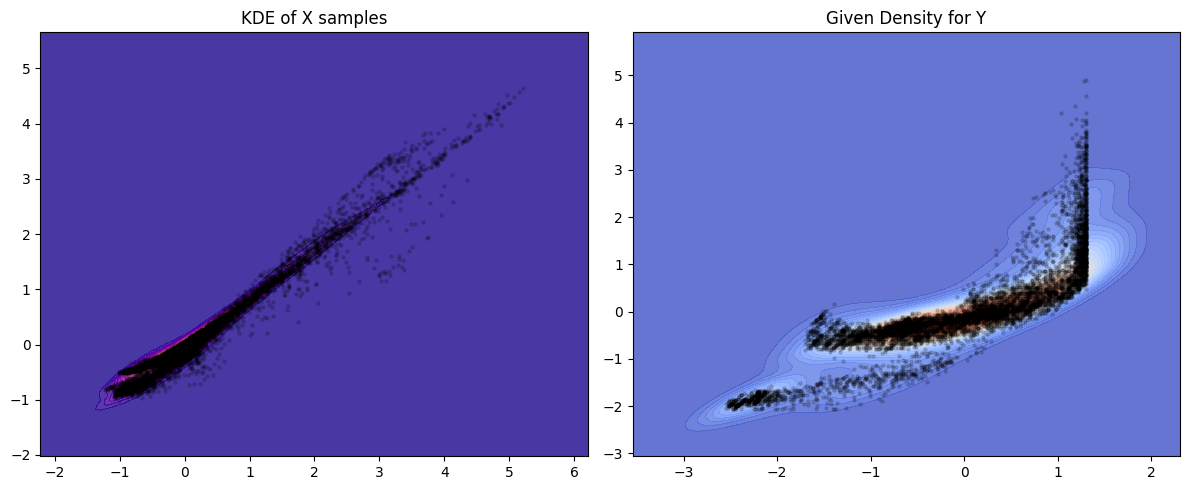

Training Progress:   5%|▍         | 996/20000 [00:29<07:34, 41.85it/s, loss=1.87]  

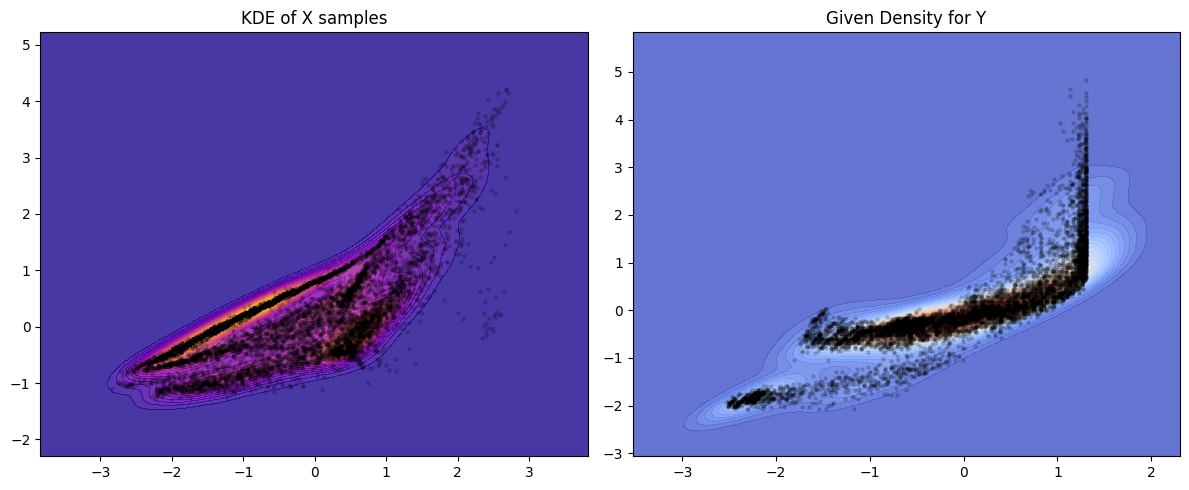

Training Progress:   7%|▋         | 1497/20000 [00:44<08:26, 36.54it/s, loss=1.89]

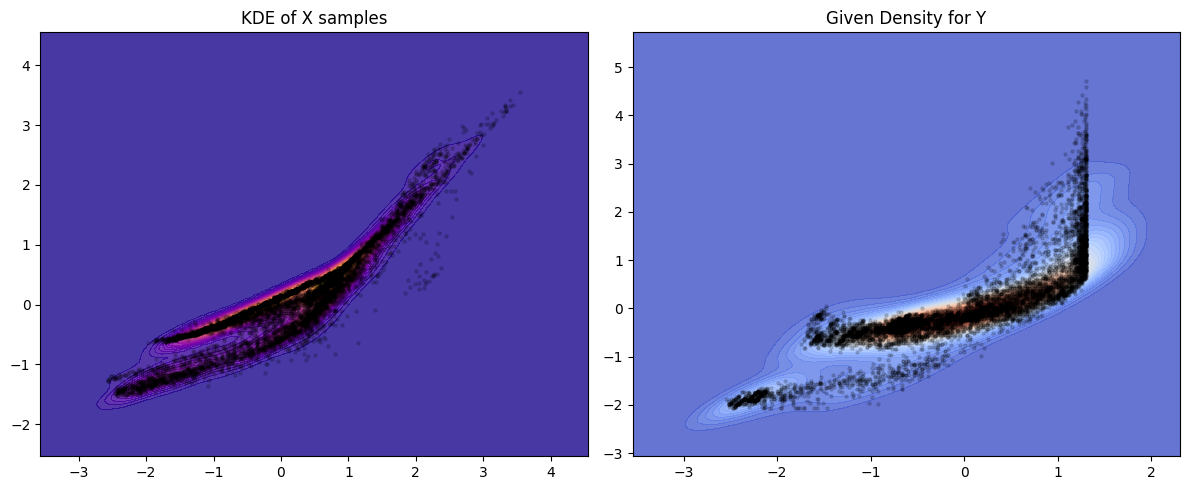

Training Progress:  10%|▉         | 1997/20000 [00:59<07:46, 38.55it/s, loss=1.67]

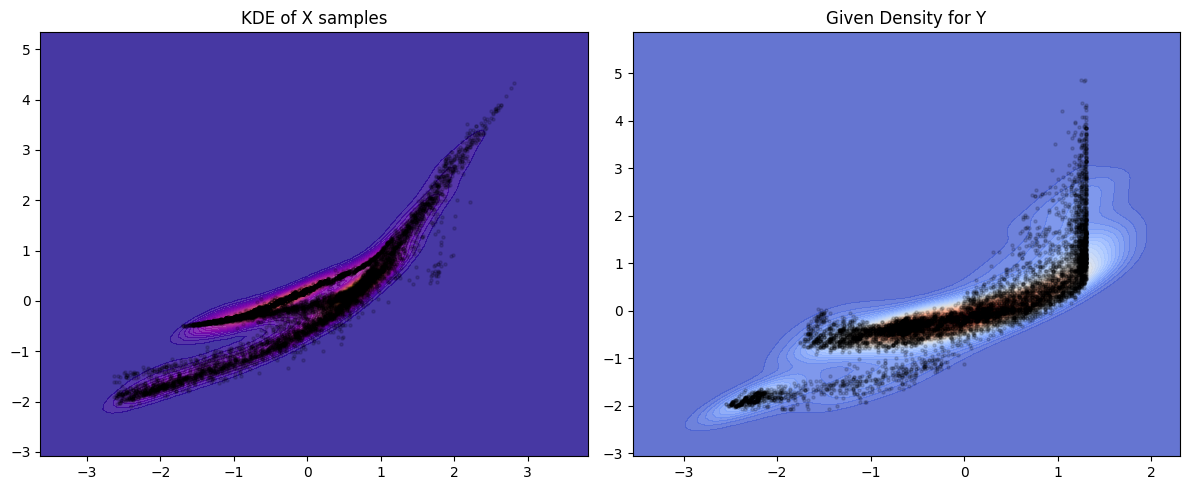

Training Progress:  12%|█▎        | 2500/20000 [01:15<07:38, 38.15it/s, loss=1.46]  

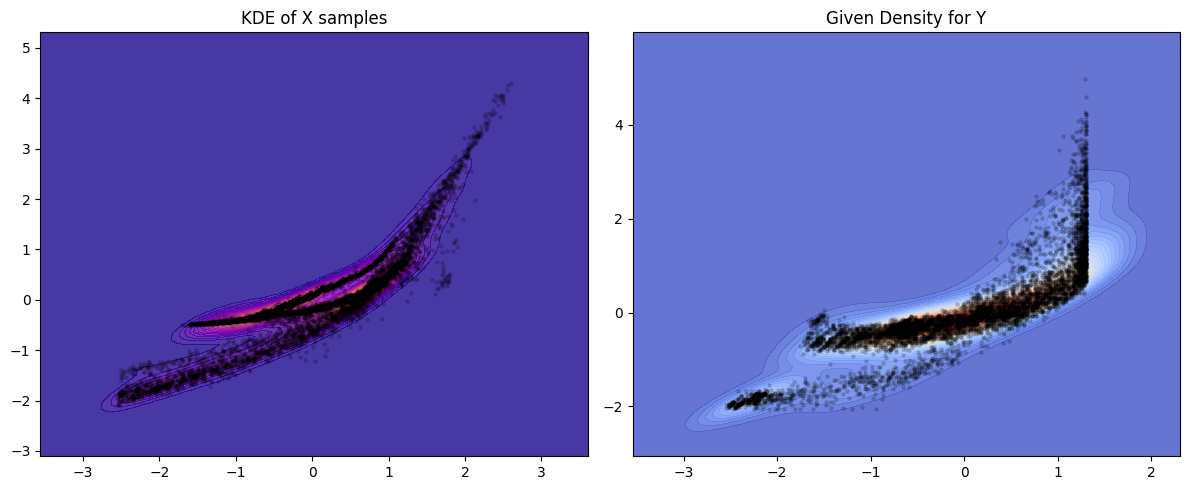

Training Progress:  15%|█▍        | 2999/20000 [01:31<07:24, 38.25it/s, loss=1.4] 

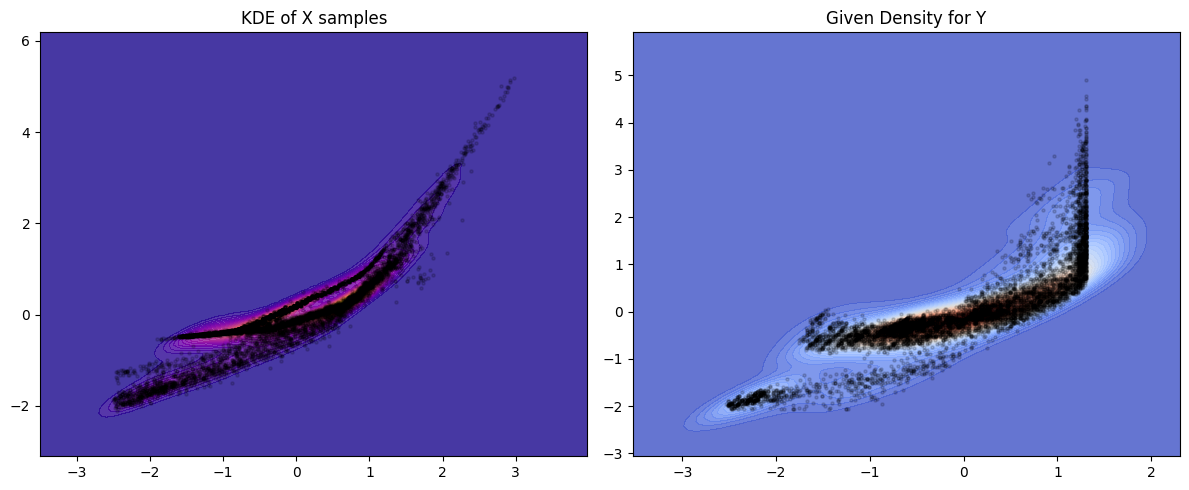

Training Progress:  18%|█▊        | 3500/20000 [01:47<07:24, 37.09it/s, loss=1.74]

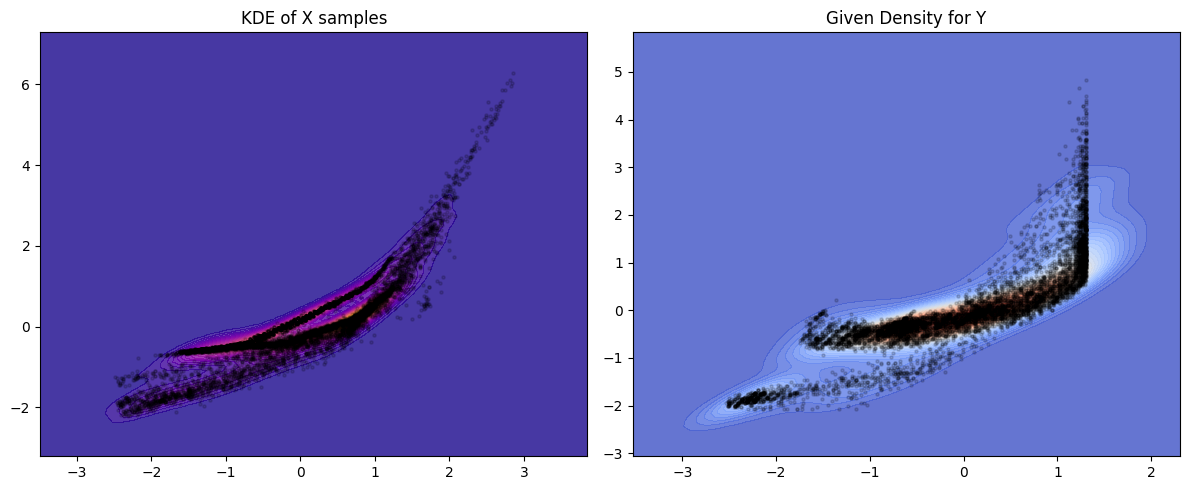

Training Progress:  20%|█▉        | 3997/20000 [02:03<06:43, 39.65it/s, loss=1.98]

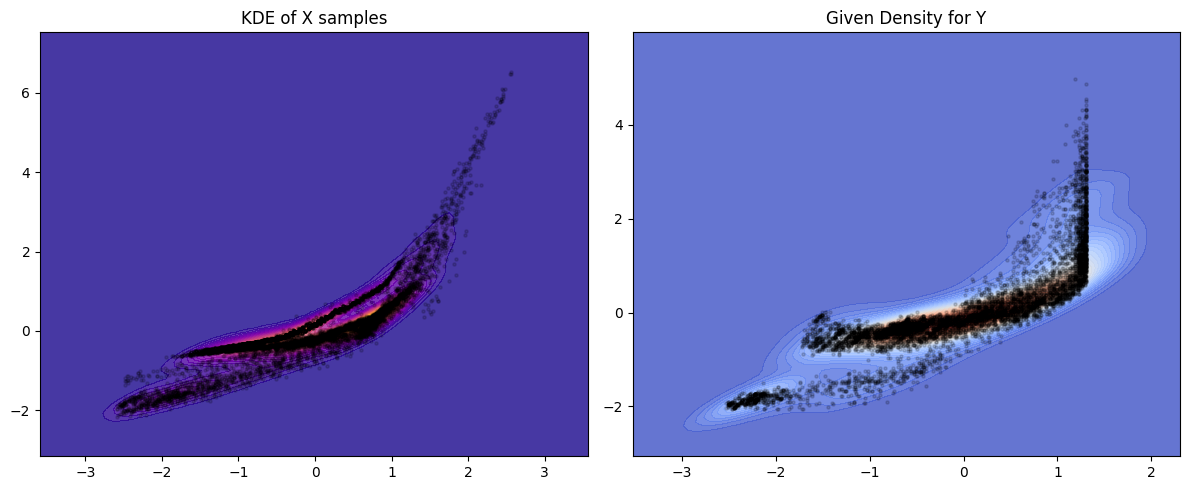

Training Progress:  22%|██▏       | 4498/20000 [02:18<07:14, 35.64it/s, loss=2.08]

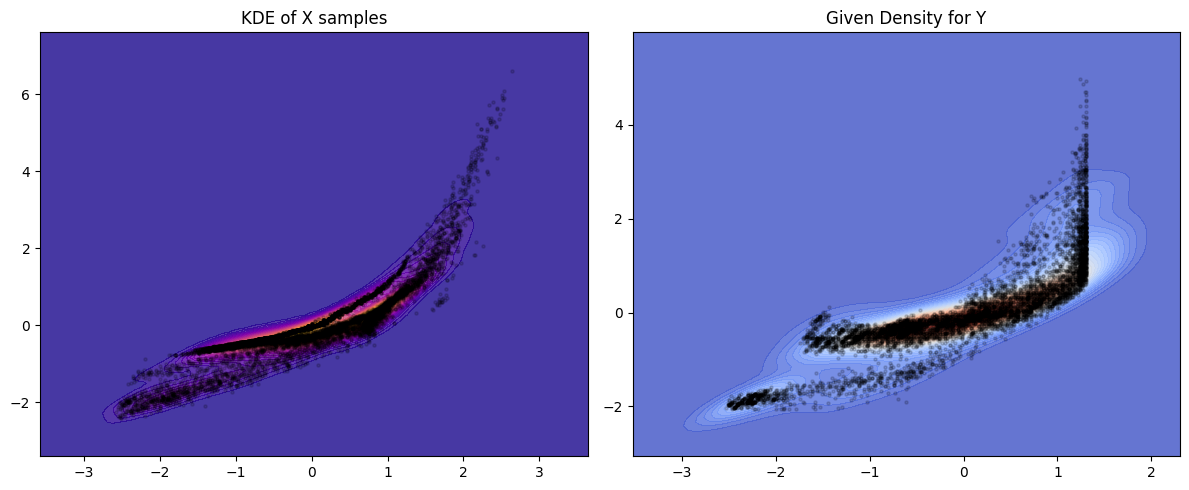

Training Progress:  25%|██▌       | 5000/20000 [02:34<06:50, 36.52it/s, loss=1.93]

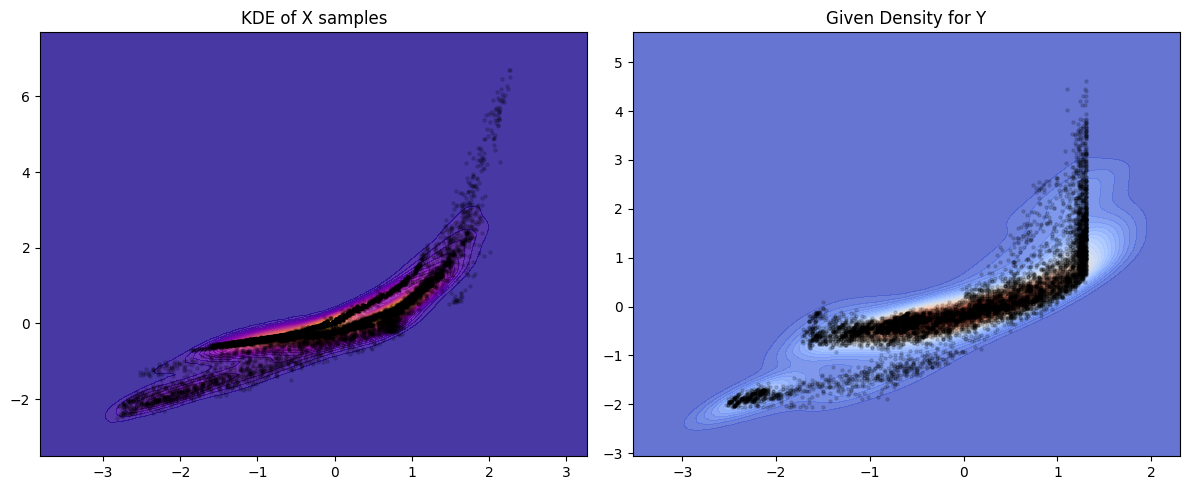

Training Progress:  27%|██▋       | 5498/20000 [02:50<06:36, 36.56it/s, loss=1.97]

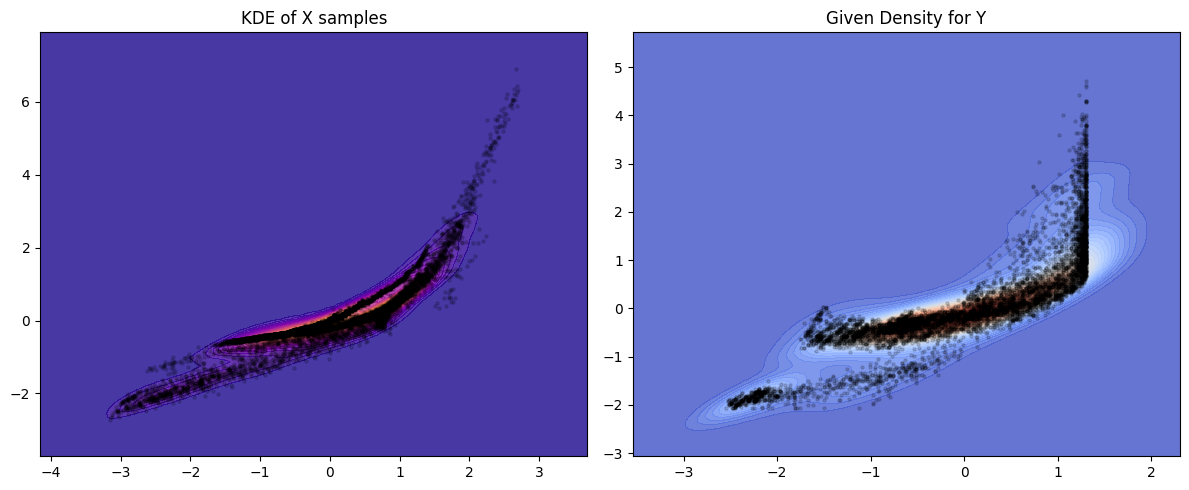

Training Progress:  30%|██▉       | 5998/20000 [03:09<06:19, 36.86it/s, loss=1.94]

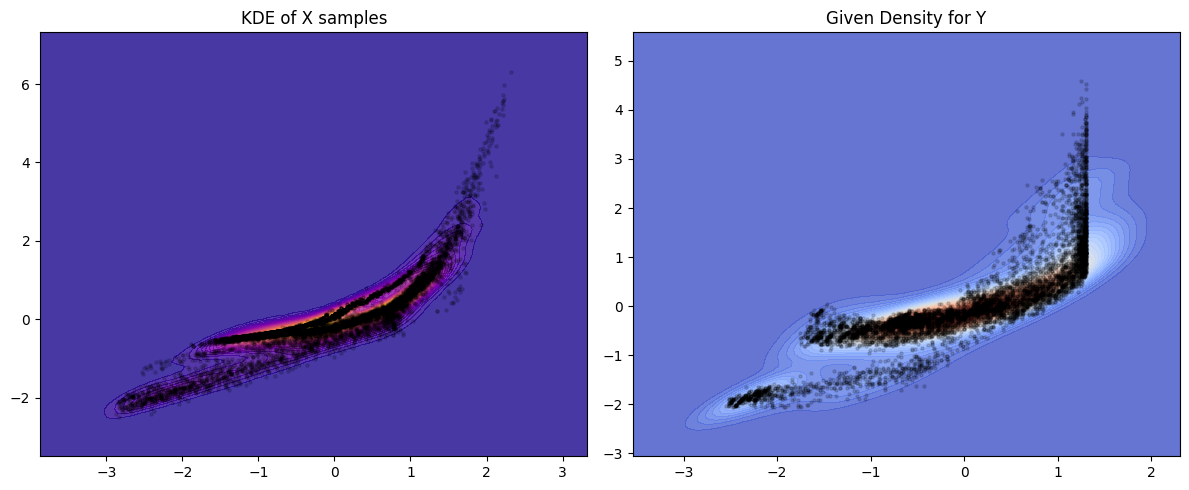

Training Progress:  32%|███▎      | 6500/20000 [03:24<05:53, 38.23it/s, loss=1.95]

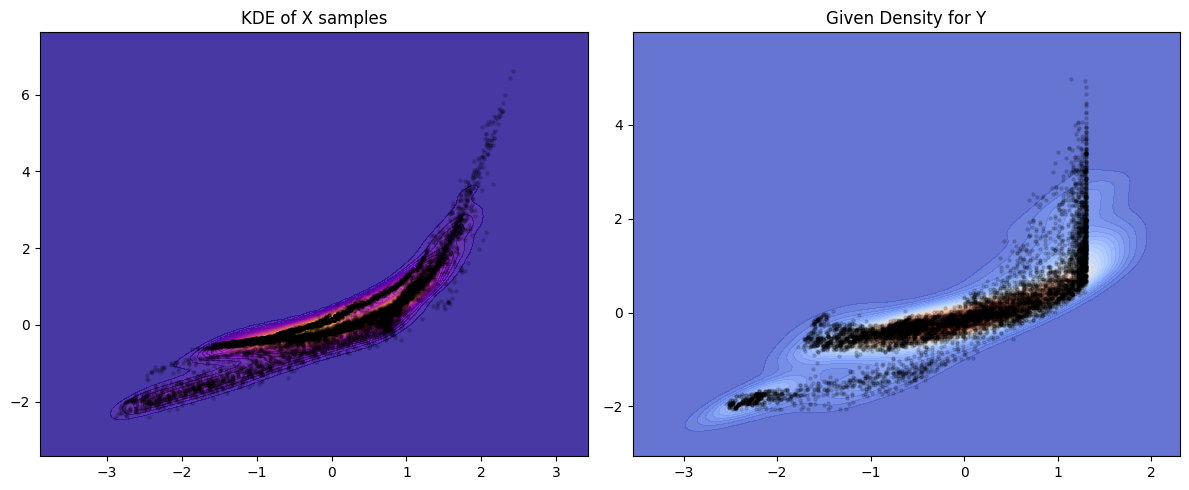

Training Progress:  35%|███▌      | 7000/20000 [03:40<05:39, 38.25it/s, loss=1.87]

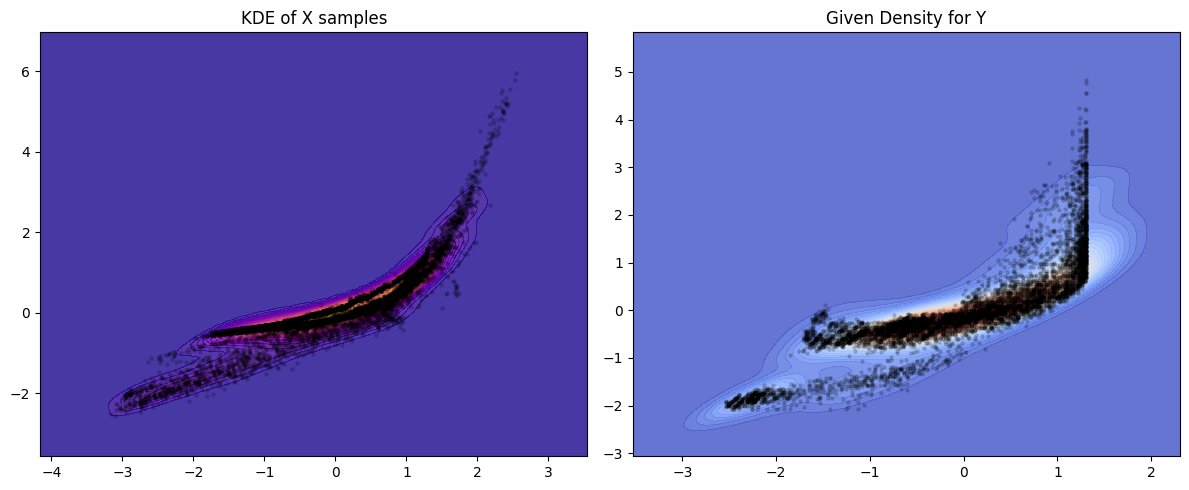

Training Progress:  38%|███▊      | 7500/20000 [03:56<05:18, 39.27it/s, loss=2.05]

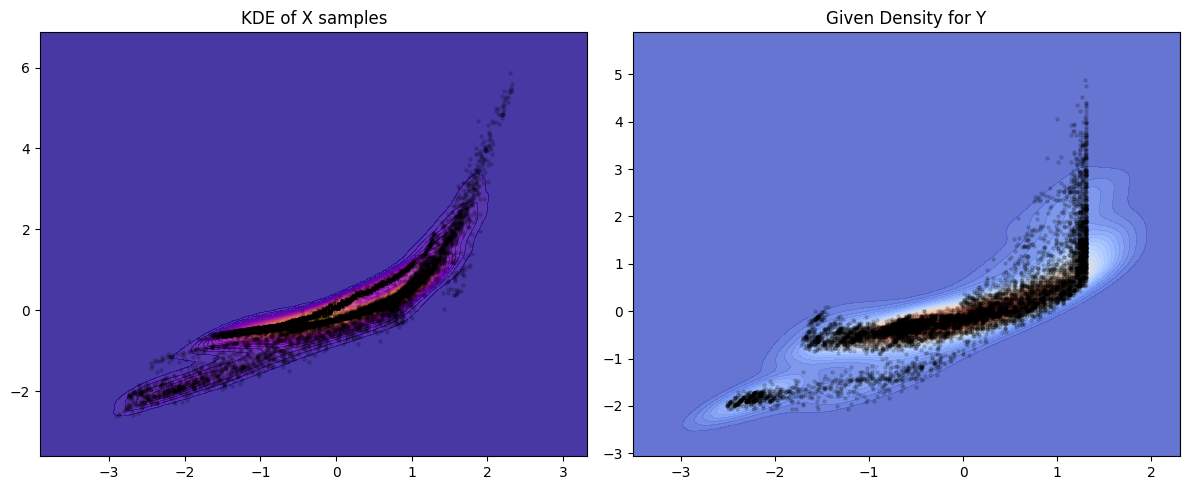

Training Progress:  40%|███▉      | 7998/20000 [04:13<05:20, 37.43it/s, loss=2.16]

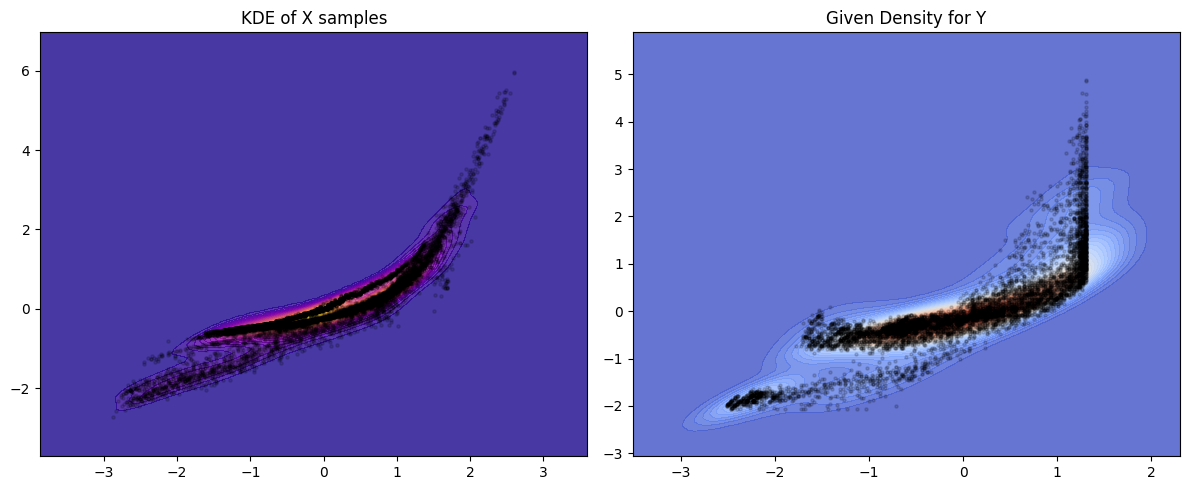

Training Progress:  42%|████▏     | 8498/20000 [04:28<05:14, 36.62it/s, loss=2.18]

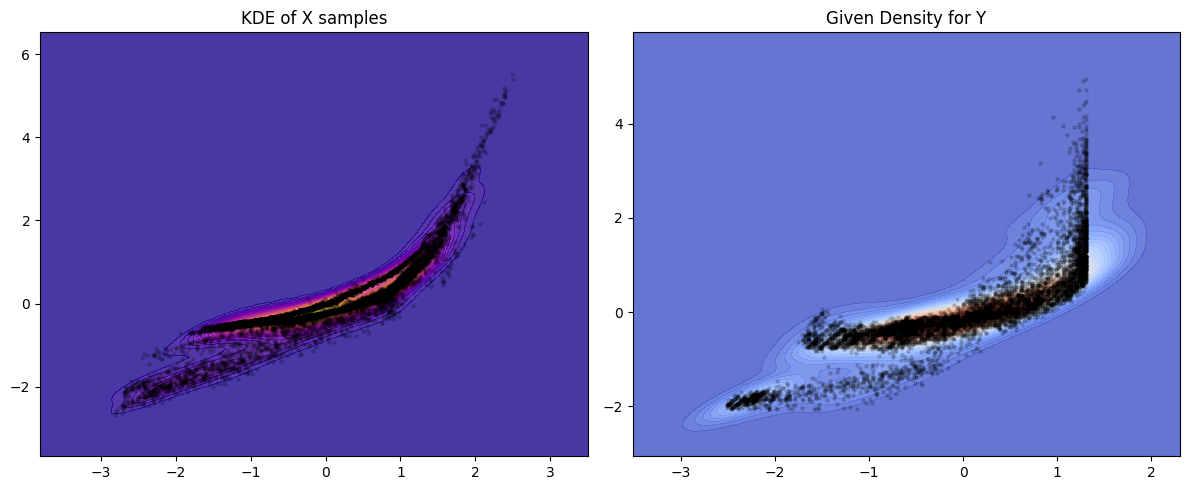

Training Progress:  45%|████▍     | 8998/20000 [04:44<05:02, 36.41it/s, loss=2.13]

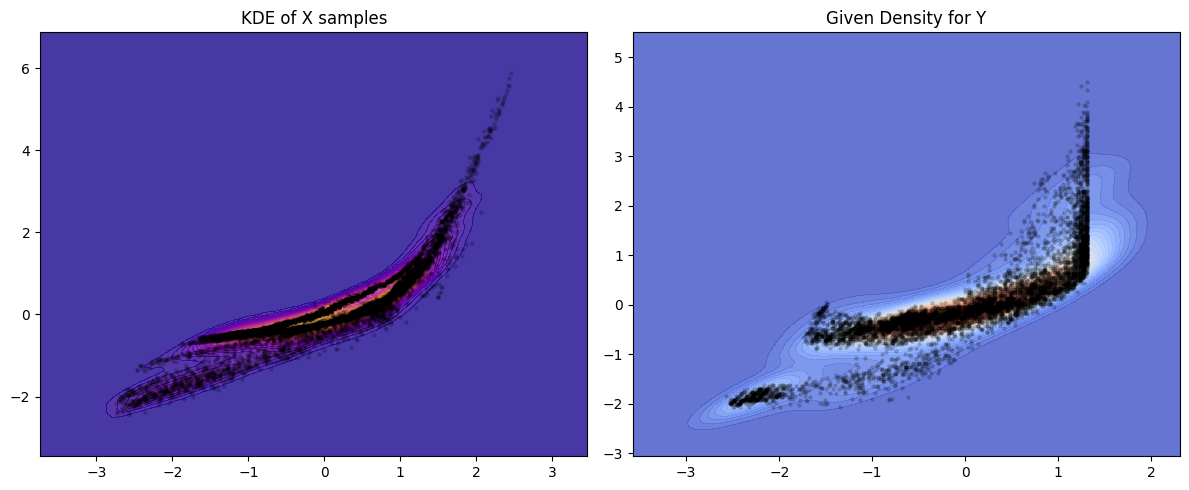

Training Progress:  48%|████▊     | 9500/20000 [05:01<04:37, 37.79it/s, loss=2.01]

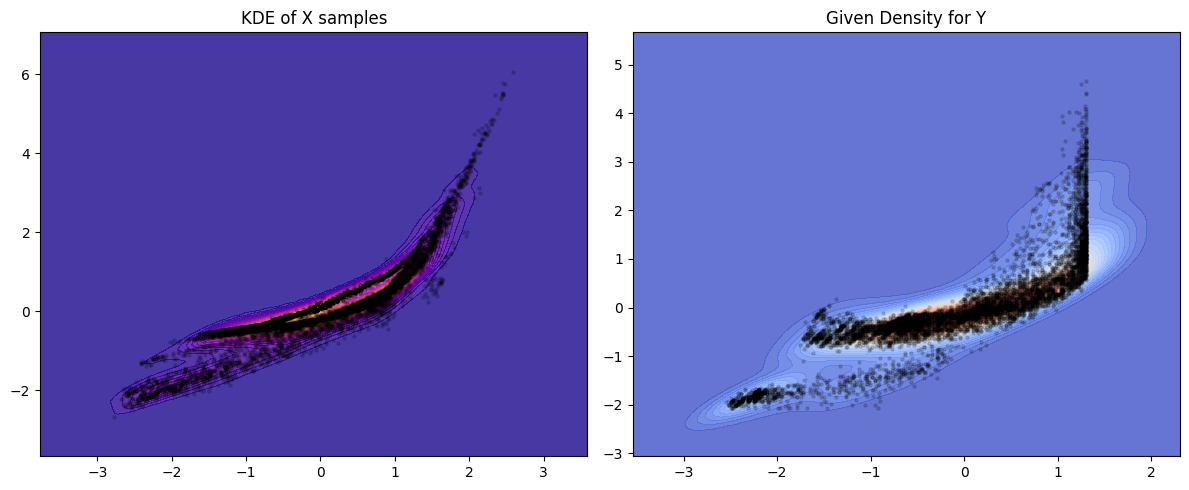

Training Progress:  50%|████▉     | 9997/20000 [05:17<04:33, 36.55it/s, loss=2.05]

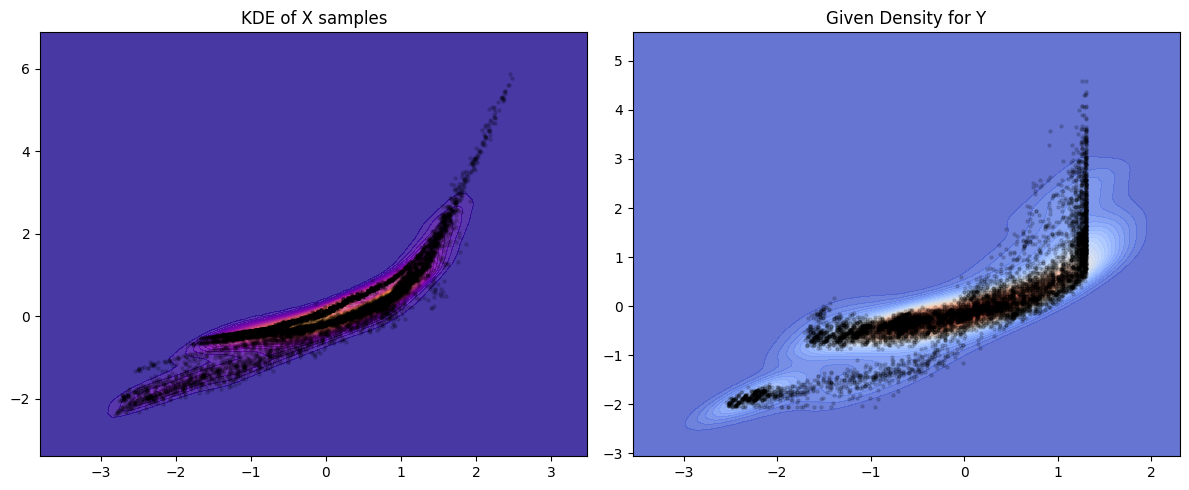

Training Progress:  52%|█████▎    | 10500/20000 [05:33<04:21, 36.31it/s, loss=2.19]

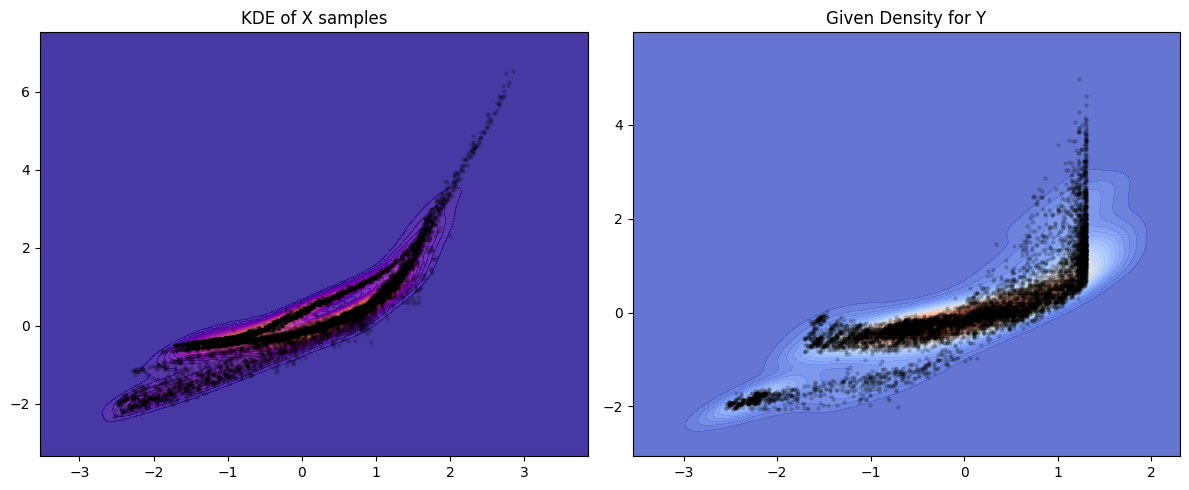

Training Progress:  55%|█████▍    | 10998/20000 [05:49<04:00, 37.43it/s, loss=1.94]

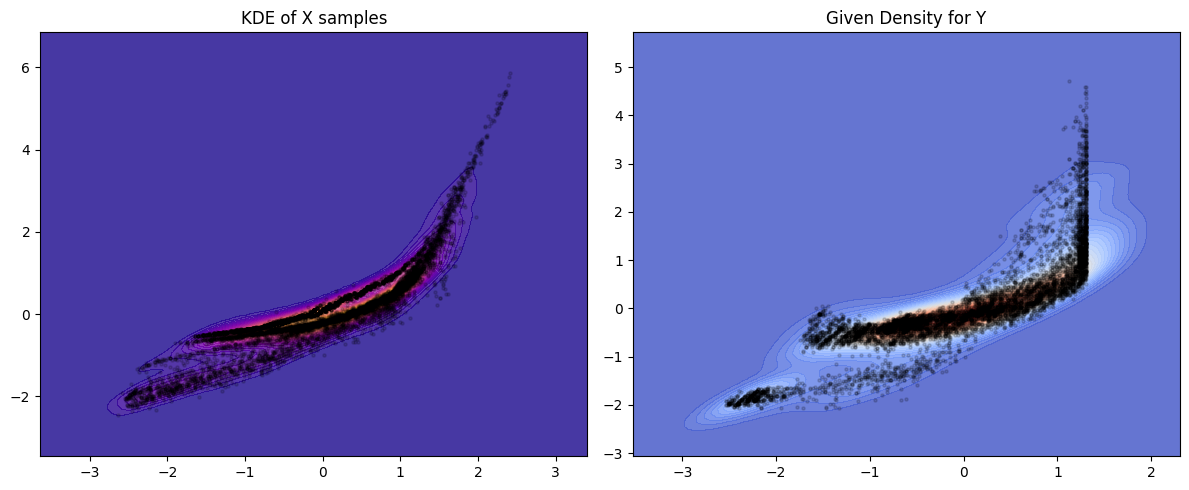

Training Progress:  57%|█████▋    | 11497/20000 [06:05<03:53, 36.35it/s, loss=1.92]

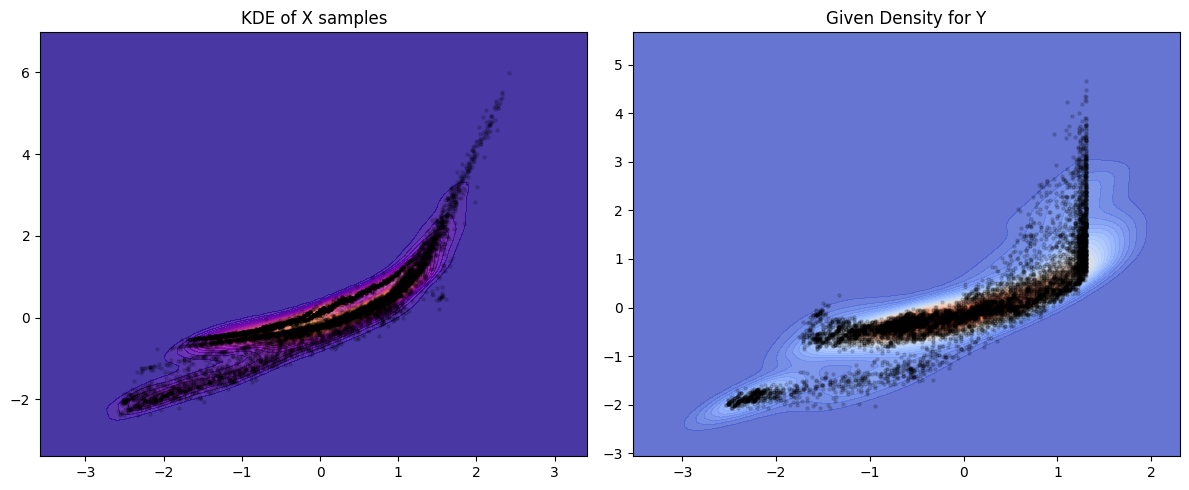

Training Progress:  60%|█████▉    | 11997/20000 [06:21<03:50, 34.70it/s, loss=2.01]

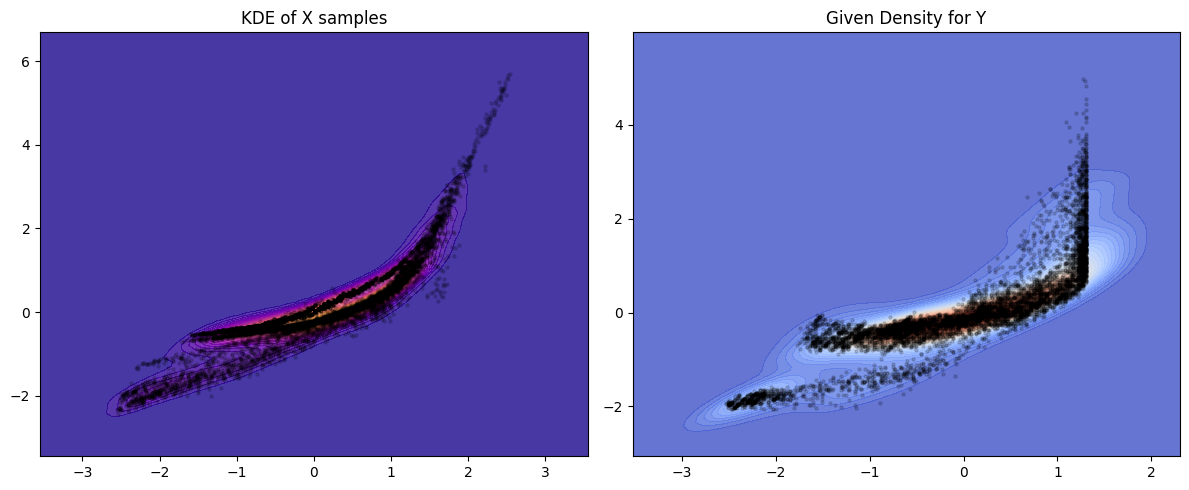

Training Progress:  62%|██████▏   | 12499/20000 [06:37<03:26, 36.37it/s, loss=1.97]

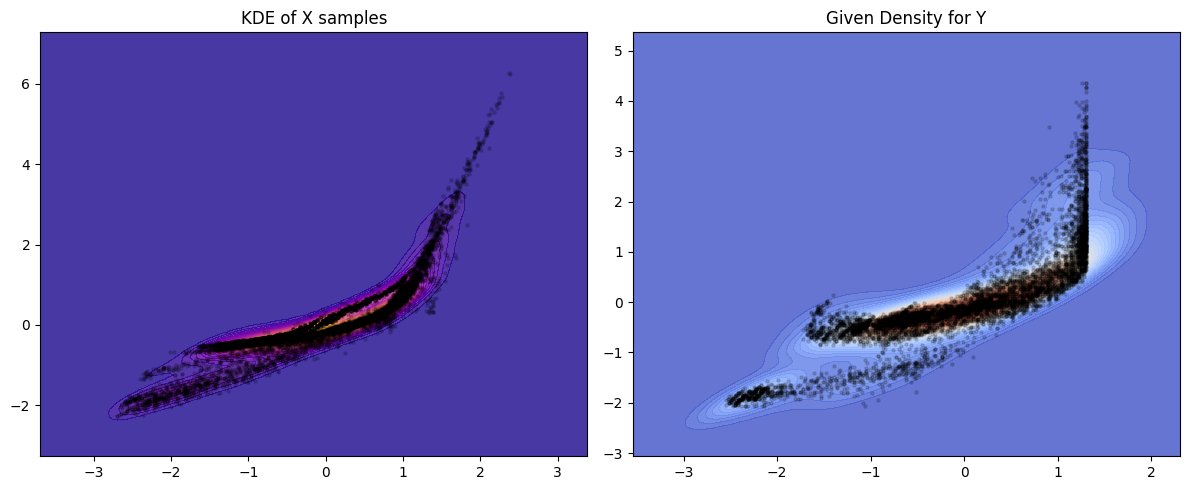

Training Progress:  65%|██████▌   | 13000/20000 [06:53<03:08, 37.12it/s, loss=2.07]

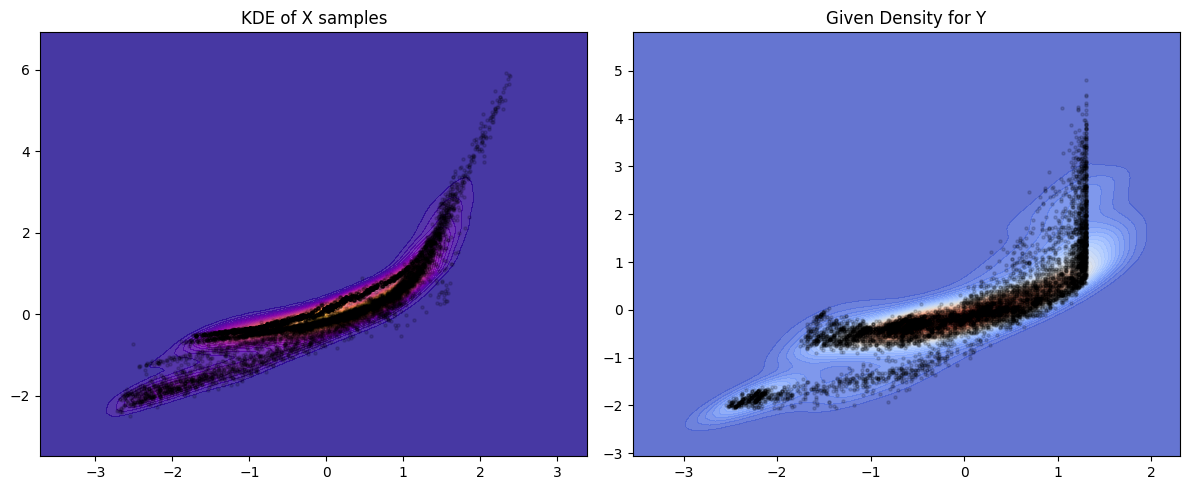

Training Progress:  68%|██████▊   | 13500/20000 [07:10<02:54, 37.18it/s, loss=2.17]

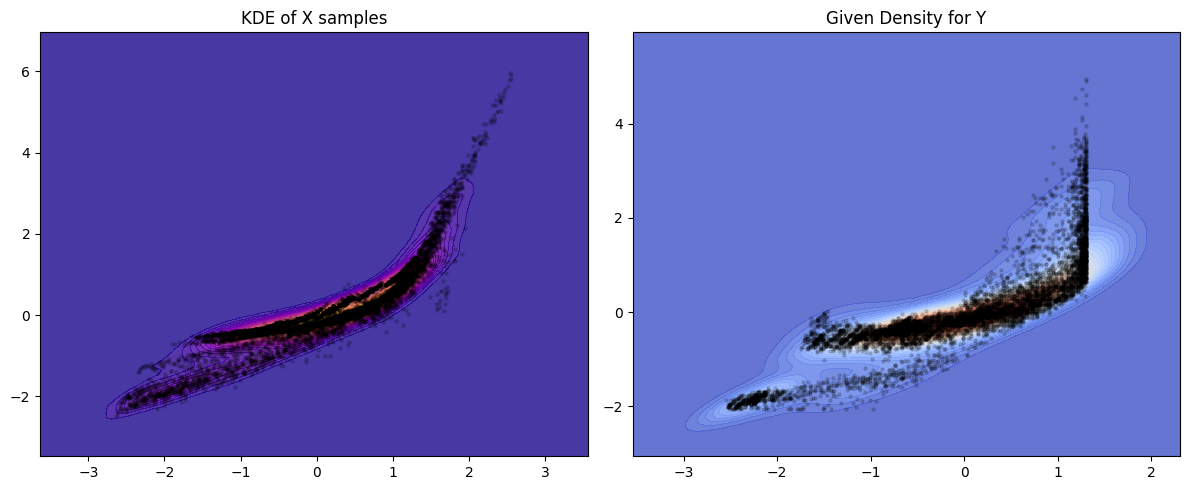

Training Progress:  70%|███████   | 14000/20000 [07:26<02:57, 33.81it/s, loss=2.11]

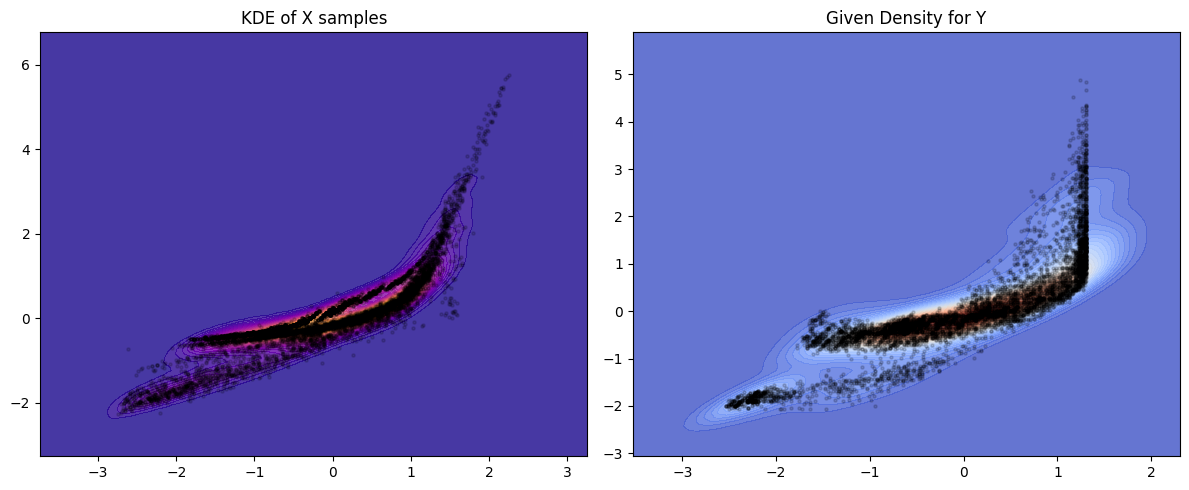

Training Progress:  72%|███████▎  | 14500/20000 [07:43<02:44, 33.35it/s, loss=2.05]

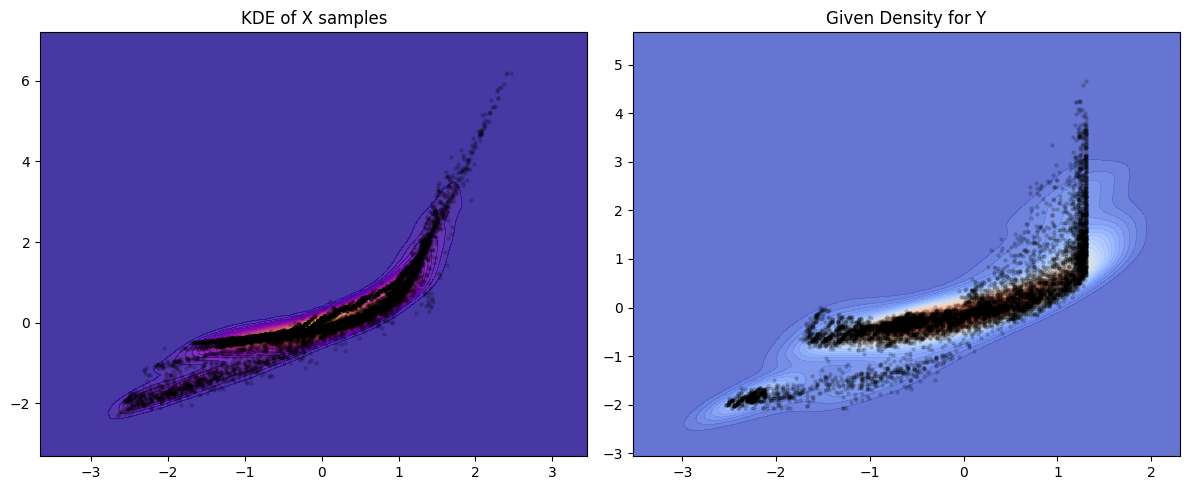

Training Progress:  75%|███████▍  | 14999/20000 [08:00<02:15, 36.90it/s, loss=2.25]

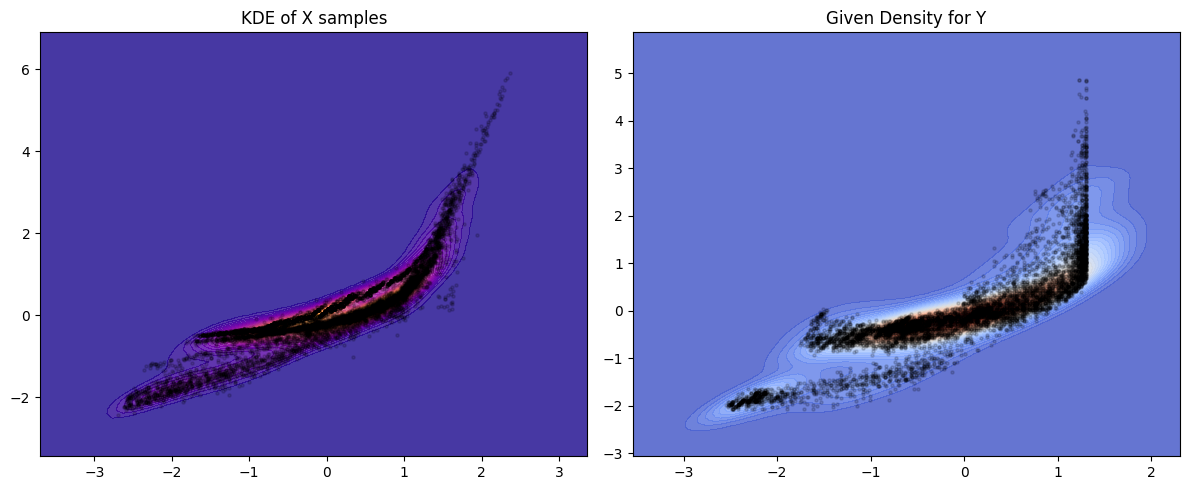

Training Progress:  78%|███████▊  | 15500/20000 [08:17<02:09, 34.86it/s, loss=2.2] 

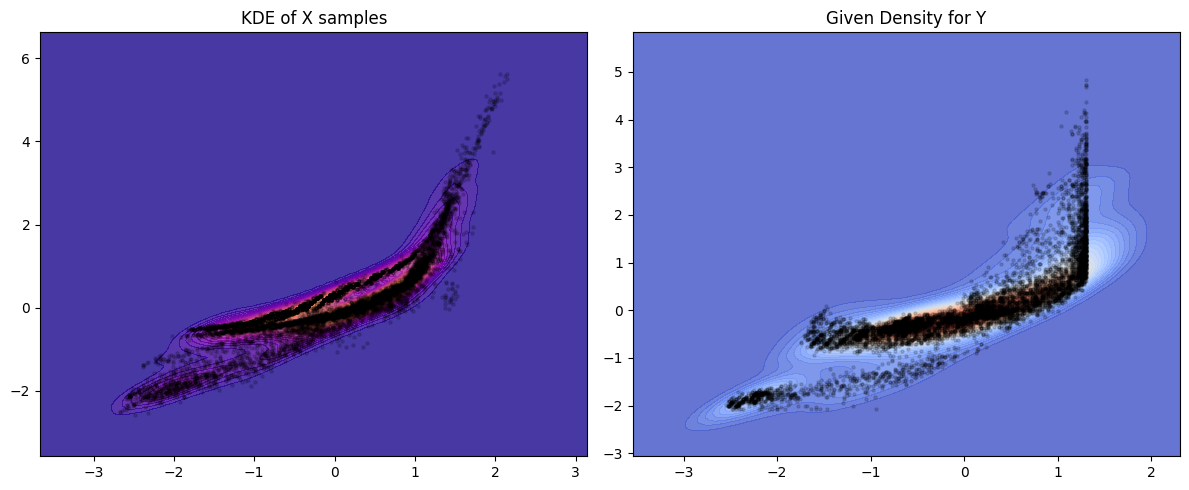

Training Progress:  80%|███████▉  | 15999/20000 [08:35<01:52, 35.69it/s, loss=2.41]

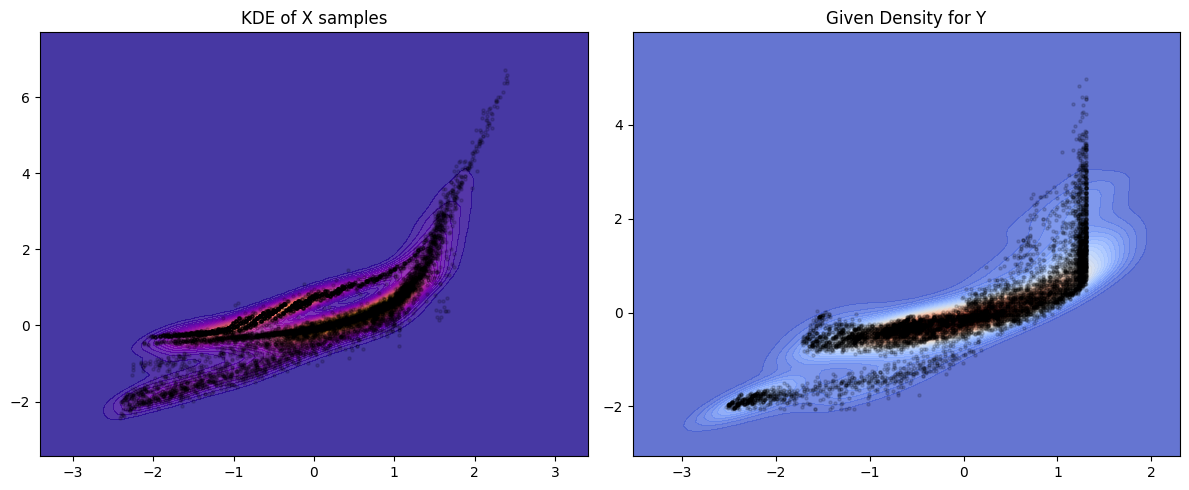

Training Progress:  82%|████████▏ | 16499/20000 [08:52<01:38, 35.40it/s, loss=2.31]

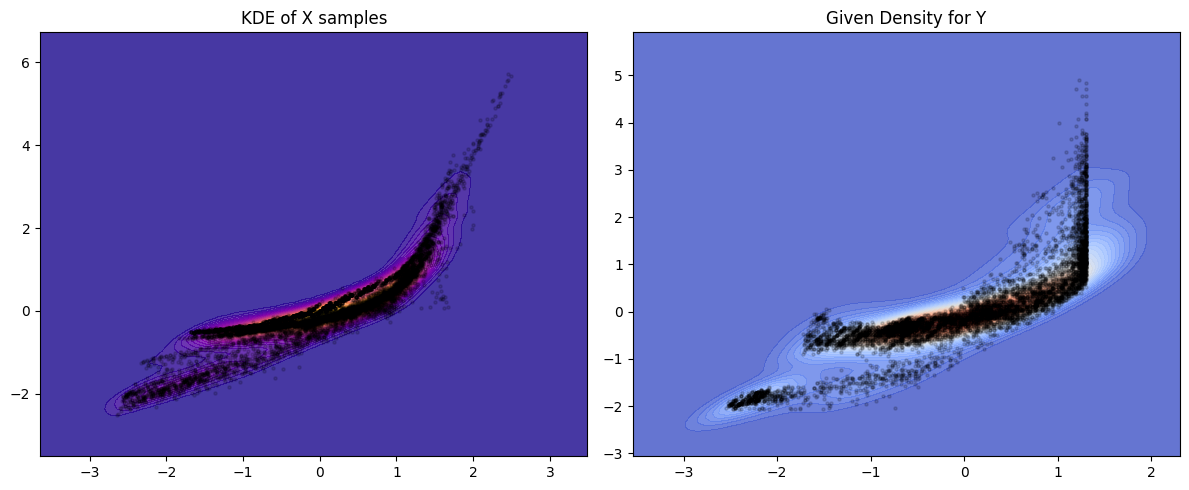

Training Progress:  85%|████████▍ | 16998/20000 [09:09<01:28, 34.06it/s, loss=2.37]

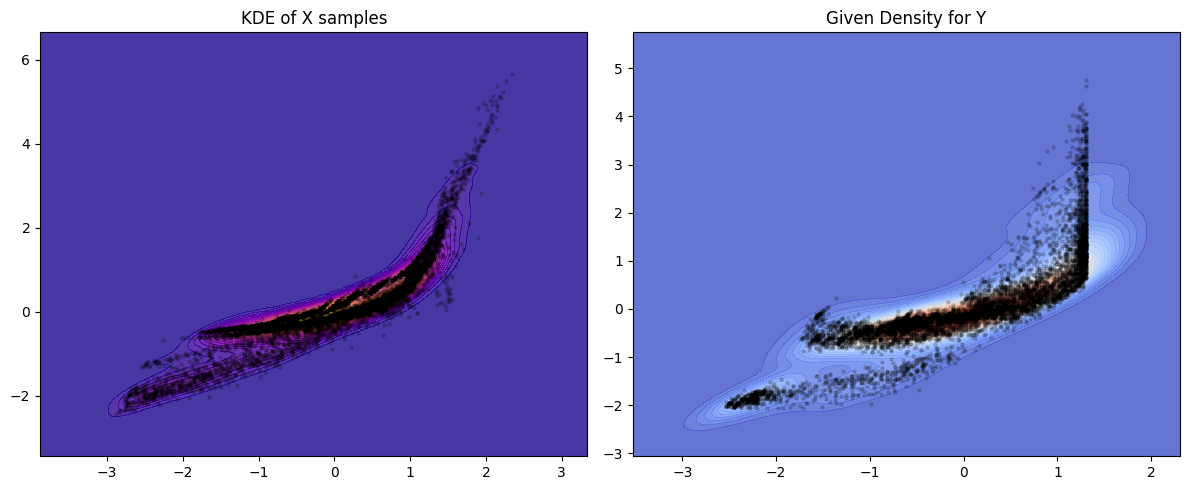

Training Progress:  87%|████████▋ | 17499/20000 [09:26<01:08, 36.41it/s, loss=2.44]

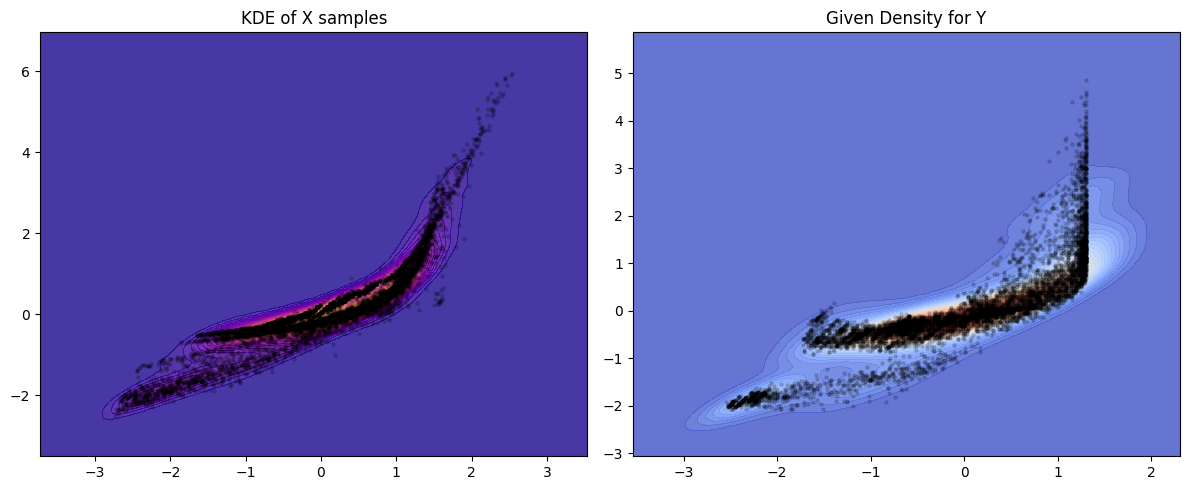

Training Progress:  90%|████████▉ | 17999/20000 [09:43<00:53, 37.30it/s, loss=2.47]

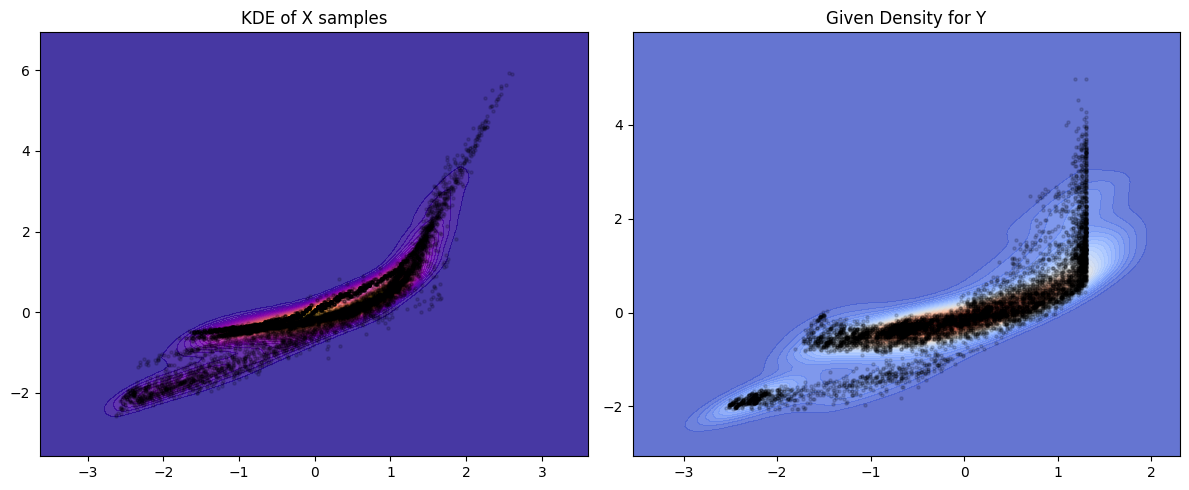

Training Progress:  92%|█████████▏| 18497/20000 [09:59<00:40, 37.13it/s, loss=2.4] 

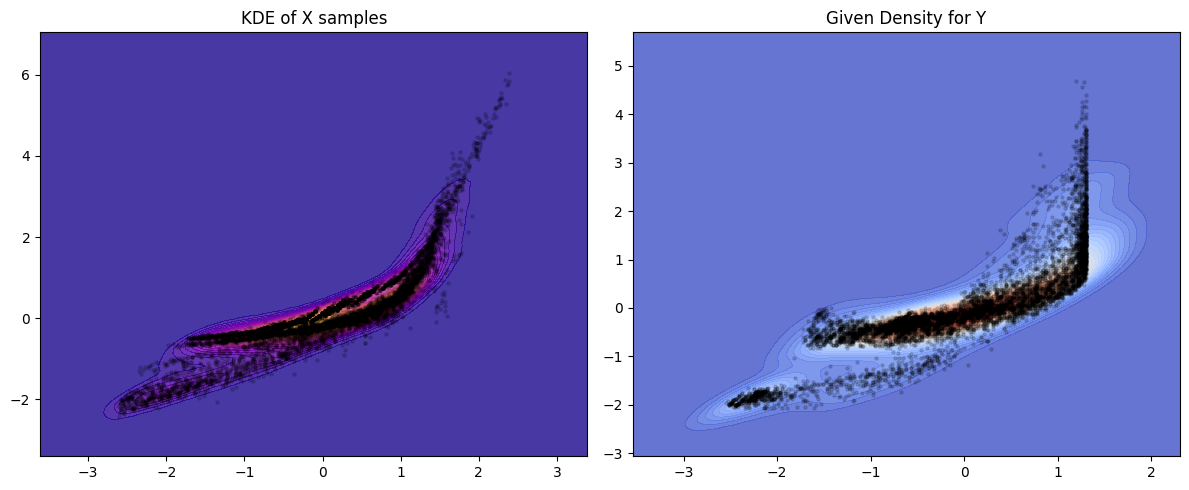

Training Progress:  95%|█████████▌| 19000/20000 [10:15<00:28, 34.74it/s, loss=2.37]

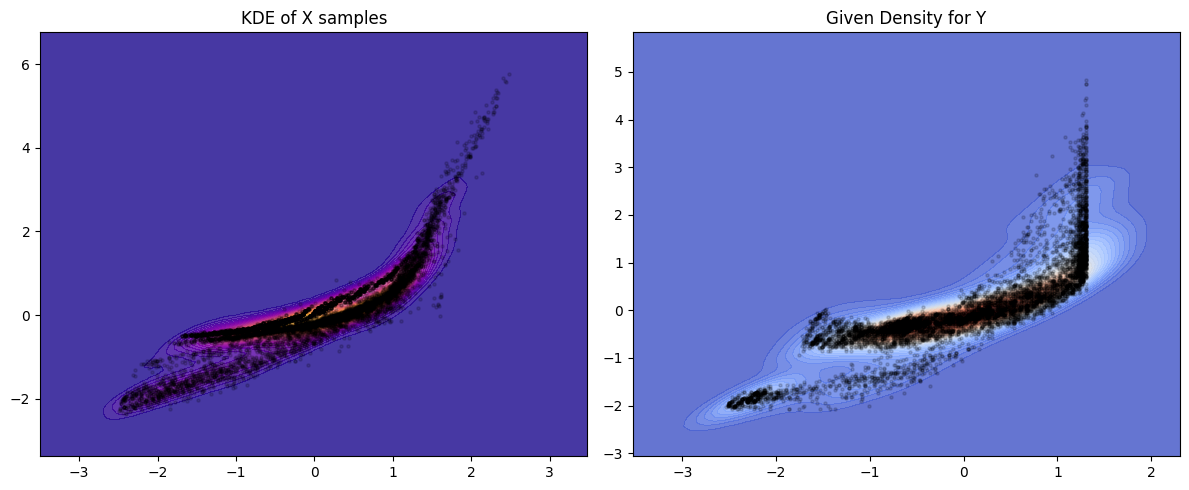

Training Progress:  97%|█████████▋| 19499/20000 [10:32<00:13, 35.88it/s, loss=2.33]

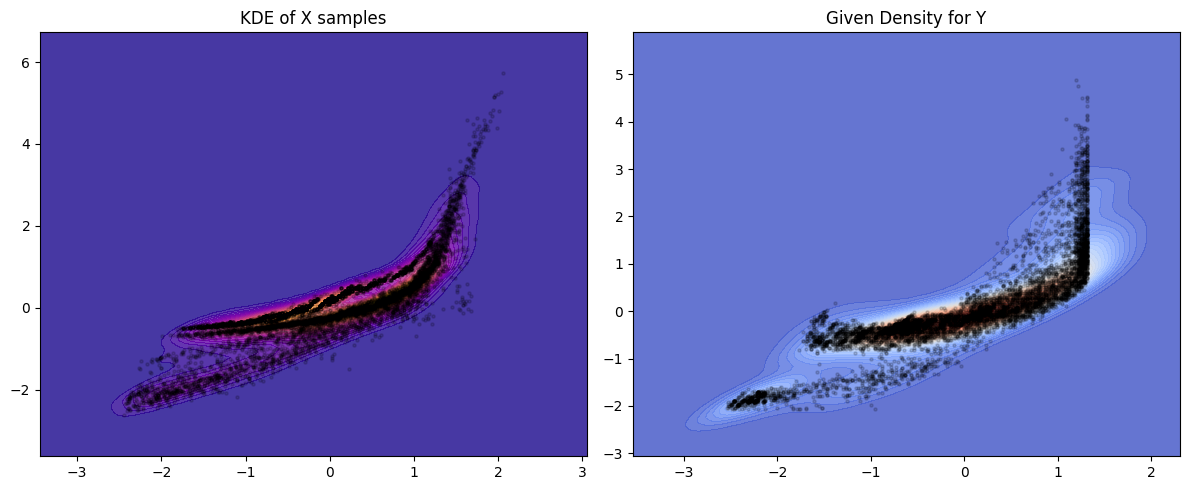

Training Progress: 100%|██████████| 20000/20000 [10:48<00:00, 30.83it/s, loss=2.37]


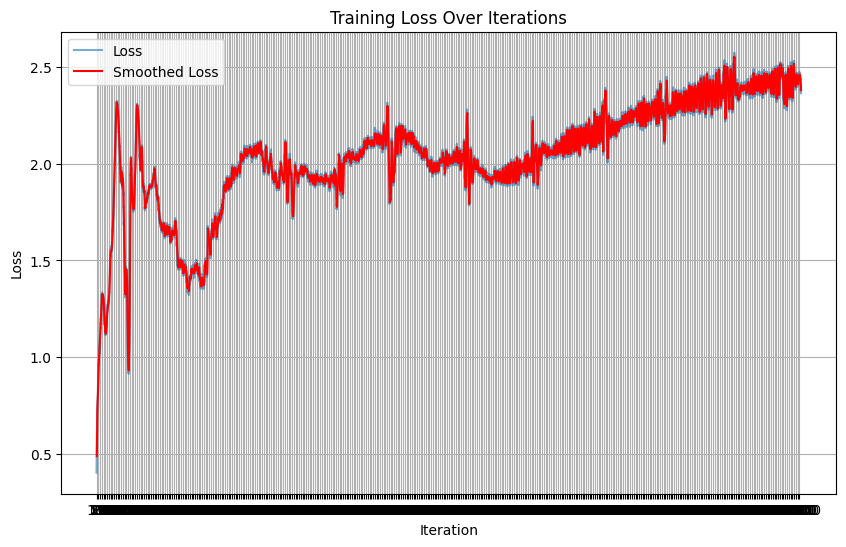

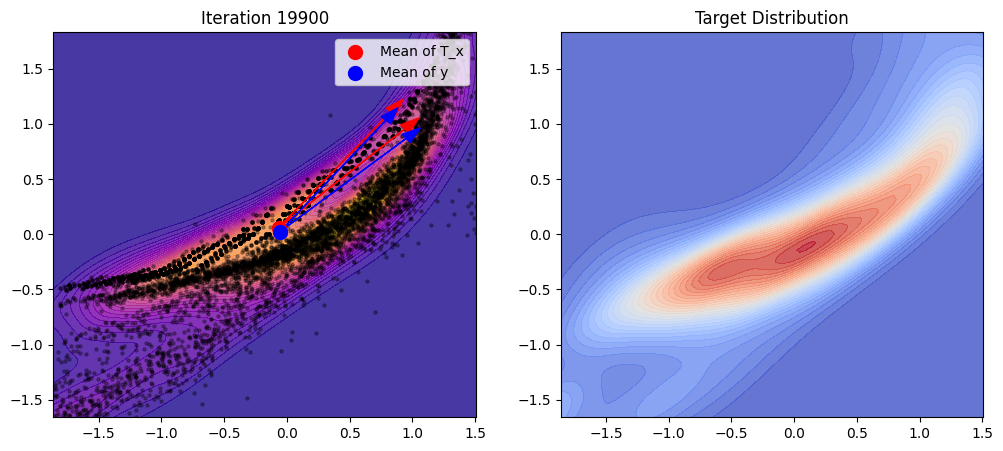

In [ ]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

""" Define the data """

x_sampler = x_image_sampler
y_sampler = y_image_sampler

""" Define p_y as the KDE of the two first dimensions of y_samples """

y_samples = y_sampler.sample(1000)

from scipy.stats import gaussian_kde

kde = gaussian_kde(y_samples[:, :2].T)
def p_y(y):
    return kde(y).reshape(-1, 1)


""" Define the network """

x_dim = 3
hidden_dim = 32
v_dim = 16
num_layers = 6
slope = 0.1
activation = nn.LeakyReLU(slope)


T = CMGN(hidden_dim, v_dim, x_dim, num_layers, activation).to(device) # Notre transport

# activation_antiderivative = lambda x: (.5 * x**2 * ((x > 0).float() + slope *  (x <= 0).float()) ).sum(dim=-1).unsqueeze(-1)
# T = MMGN(x_dim, v_dim, hidden_dim, num_layers, activation, activation_antiderivative)

print(f'Number of parameters: {sum(p.numel() for p in T.parameters())}')

""" Define the optimization parameters """


learning_rate = 1e-3
iterations = 20000
batch_size = 2**13
print(f'Batch size: {batch_size}')

plot_every_n = 100

""" Define the divergence metric """

# divergence_metric = GaussianKLDivergence(target_mean=y_gmm.means[0], target_cov=y_gmm.covs[0], device=device)

divergence_metric = DualWassersteinDistance(
    input_dim=x_dim, 
    hidden_dim=32,
    critic_lr=2e-4,
    critic_iterations=1,
    lambda_gp=10

)
divergence_metric.critic.to(device)

# Create MMD distance calculator
# mmd_distance = MMDDistance(kernel_width=0.5)

""" Train the model """


train_OT(
    x_sampler, 
    y_sampler, 
    learning_rate, 
    iterations, 
    T, 
    batch_size,
    divergence_metric, 
    device=device,
    plot_every_n=plot_every_n,
    p_y=p_y
)

[167.39340982  75.98453146  58.41945943] [65.13790809 36.34626297 21.24211938]


(-0.5, 1023.5, 682.5, -0.5)

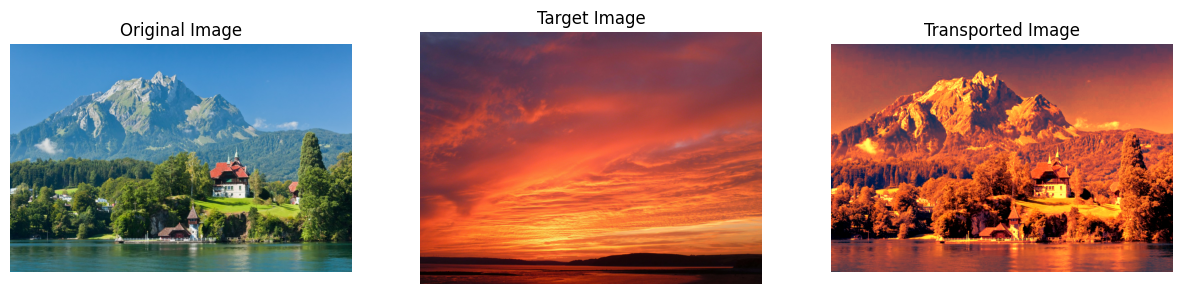

In [ ]:
image = plt.imread('test_images/sunset.jpeg')
mean = image.mean(axis=(0, 1))
std = image.std(axis=(0, 1))

print(mean, std)

points = x_sampler.points

T_x = T(torch.Tensor(points).to(device)).detach().cpu().numpy()/20

T_x_ = T_x * std[None, :] + mean[None, :]

image = plt.imread('test_images/montagne.jpg')

T_x_ = T_x_.reshape(image.shape).clip(0, 255)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(plt.imread('test_images/sunset.jpeg'))
plt.title('Target Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(T_x_.astype(np.uint8))
plt.title('Transported Image')
plt.axis('off')


In [ ]:
# Generative MNIST example

class ZSampler:
    def sample(self, n_samples):
        return torch.randn(n_samples, 28*28)


import torchvision
import torchvision.transforms as transforms
class MNISTSampler:
    def __init__(self):
        self.mnist = torchvision.datasets.MNIST(
            root='./data',
            train=True,
            transform=transforms.ToTensor(),
            download=True
        )

    def sample(self, n_samples):
        indices = np.random.choice(len(self.mnist), n_samples)
        return (self.mnist.data[indices].float().view(n_samples, -1) / 255 - 0.1304) / 0.3061



Number of parameters: 1854160
Batch size: 1024
784


Training Progress: 100%|██████████| 80000/80000 [12:47:30<00:00,  1.74it/s, loss=109]   


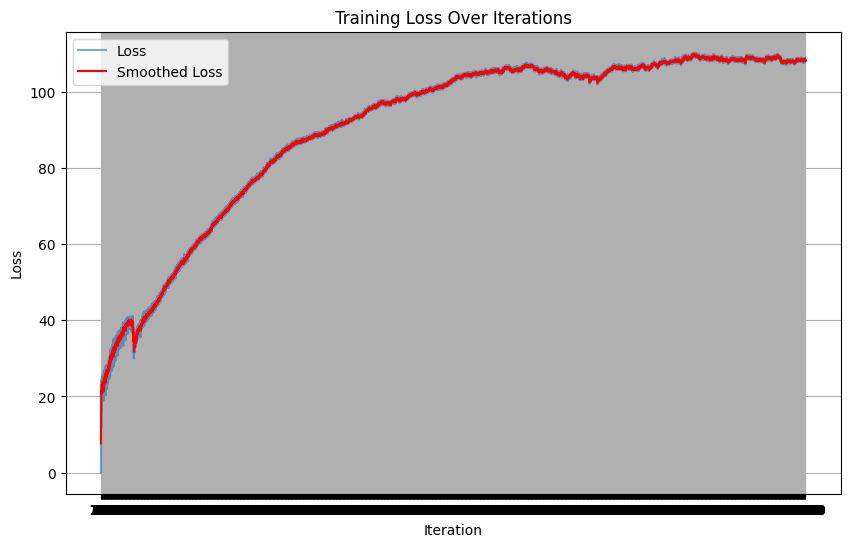

CMGN(
  (W): Linear(in_features=784, out_features=1568, bias=False)
  (V): Linear(in_features=784, out_features=784, bias=False)
  (biases): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1568 (cuda:0)]
      (1): Parameter containing: [torch.float32 of size 1568 (cuda:0)]
      (2): Parameter containing: [torch.float32 of size 1568 (cuda:0)]
      (3): Parameter containing: [torch.float32 of size 1568 (cuda:0)]
      (4): Parameter containing: [torch.float32 of size 1568 (cuda:0)]
      (5): Parameter containing: [torch.float32 of size 1568 (cuda:0)]
  )
  (activation): LeakyReLU(negative_slope=0.1)
)

In [ ]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

""" Define the data """

z_sampler = ZSampler()
x_sampler = MNISTSampler()

""" Define the network """

x_dim = 28*28
hidden_dim = 28*28*2
v_dim = 28*28
num_layers = 6
slope = 0.1
activation = nn.LeakyReLU(slope)


T = CMGN(hidden_dim, v_dim, x_dim, num_layers, activation).to(device) # Notre transport

# activation_antiderivative = lambda x: (.5 * x**2 * ((x > 0).float() + slope *  (x <= 0).float()) ).sum(dim=-1).unsqueeze(-1)
# T = MMGN(x_dim, v_dim, hidden_dim, num_layers, activation, activation_antiderivative)

print(f'Number of parameters: {sum(p.numel() for p in T.parameters())}')

""" Define the optimization parameters """


learning_rate = 1e-3
iterations = 80000
batch_size = 2**10
print(f'Batch size: {batch_size}')

plot_every_n = 100

""" Define the divergence metric """

# divergence_metric = GaussianKLDivergence(target_mean=y_gmm.means[0], target_cov=y_gmm.covs[0], device=device)
print(x_dim)
divergence_metric = DualWassersteinDistance(
    input_dim=x_dim, 
    hidden_dim=28*28*3,
    critic_lr=2e-4,
    critic_iterations=1,
    lambda_gp=10

)
divergence_metric.critic.to(device)

# Create MMD distance calculator
# mmd_distance = MMDDistance(kernel_width=0.5)

""" Train the model """


train_OT(
    z_sampler, 
    x_sampler, 
    learning_rate, 
    iterations, 
    T, 
    batch_size,
    divergence_metric, 
    device=device,
    plot_every_n=plot_every_n,
    visualize=False
)

In [ ]:
# Save the weights of the model
torch.save(T.state_dict(), 'mnist_model.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


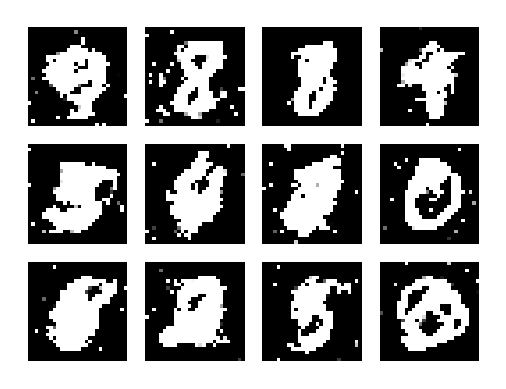

In [ ]:
z_samples = z_sampler.sample(12)
t_x = T(z_samples.to(device)).detach().cpu()
# plot the grid of images using torchvision.utils.make_grid
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def show_images(images, nrow=4):
    grid = vutils.make_grid(images, nrow=nrow, padding=5, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

show_images(t_x.view(-1, 1, 28, 28), nrow=4)